In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [3]:
#Gerando as features que serão usadas no modelo
import sys, os
sys.path.append(os.path.abspath('..'))
from pre_processamento.processamento_dados import processamento
# --- Importações necessárias ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df = processamento()
#Gerando os dados de hora e mês para situar o modelo
df['hora'] = df.index.hour
df['mes'] = df.index.month
#Gerando os datasets de treino validação e teste
# Definindo o período de treino (2010)
train_end = '2010-12-31 23:00:00'
X_train = df[['hora', 'mes']].loc[:train_end]
y_train = df['TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)'].loc[:train_end]
#Definindo o período de validação (2011)
val_end = '2011-12-31 23:00:00'
val_start = '2011-01-01 00:00:00'
X_val = df[['hora', 'mes']].loc[val_start:val_end]
y_val = df['TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)'].loc[val_start:val_end]
#Definindo o período de teste (2012)
test_start = '2012-01-01 00:00:00'
X_test = df[['hora', 'mes']].loc[test_start:]
y_test = df['TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)'].loc[test_start:]


In [18]:
X_train.head()

,hora,mes
DATETIME,,
2010-01-01 00:00:00,0,1
2010-01-01 01:00:00,1,1
2010-01-01 02:00:00,2,1
2010-01-01 03:00:00,3,1
2010-01-01 04:00:00,4,1


In [12]:
y_train.head()

DATETIME
2010-01-01 00:00:00    21.6
2010-01-01 01:00:00    21.1
2010-01-01 02:00:00    20.8
2010-01-01 03:00:00    20.5
2010-01-01 04:00:00    20.0
Name: TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C), dtype: float64

In [19]:
X_val.head()

,hora,mes
DATETIME,,
2011-01-01 00:00:00,0,1
2011-01-01 01:00:00,1,1
2011-01-01 02:00:00,2,1
2011-01-01 03:00:00,3,1
2011-01-01 04:00:00,4,1



Dados prontos! Agora o Teste contém apenas o período equivalente ao Treino.

=== 4.1 VISUALIZAÇÃO DA SÉRIE TEMPORAL ===


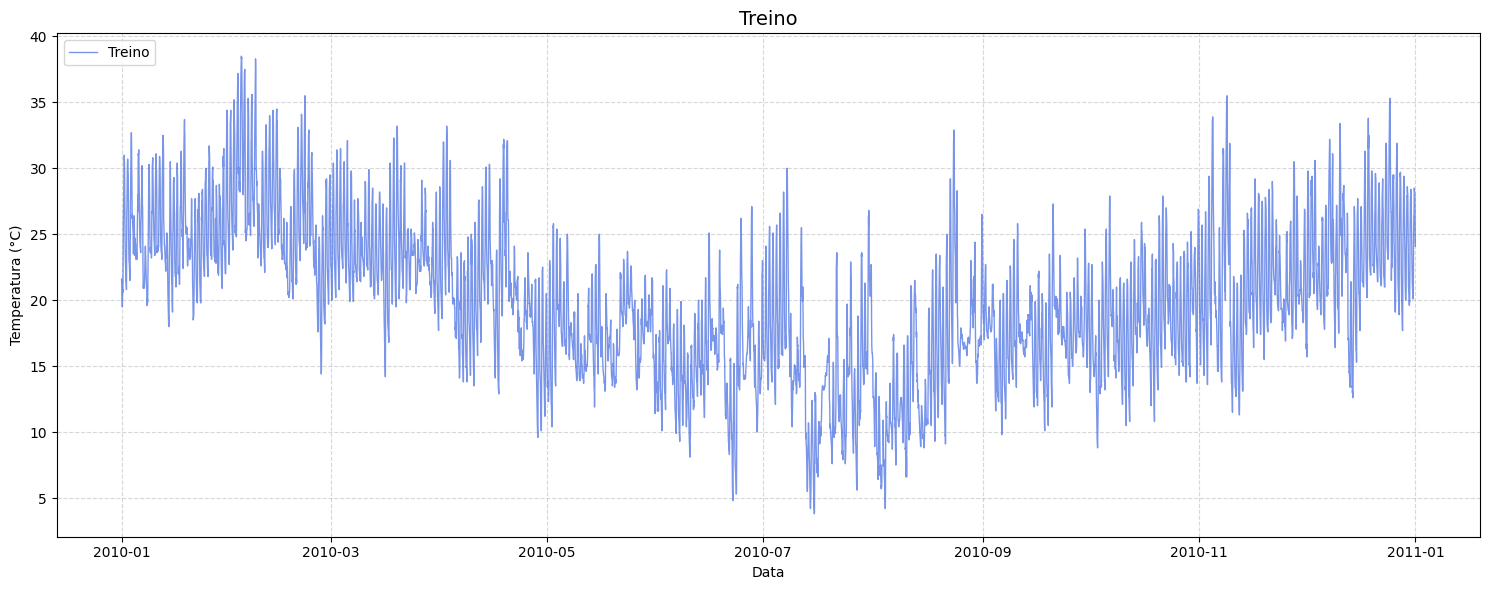

In [4]:
#Normalização
scaler = StandardScaler()

# Ajusta a régua (fit) apenas no TREINO
X_train_scaled = scaler.fit_transform(X_train)

# Aplica a régua na Validação e no Teste
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Converte de volta para DataFrame para manter colunas e índices
X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index)

print("\nDados prontos! Agora o Teste contém apenas o período equivalente ao Treino.")

# ==============================================================================
# 4.1 VISUALIZAÇÃO DA DIVISÃO TEMPORAL
# ==============================================================================
print("\n=== 4.1 VISUALIZAÇÃO DA SÉRIE TEMPORAL ===")

plt.figure(figsize=(15, 6))

# 1. Plot do Treino (Azul)
plt.plot(y_train.index, y_train, label='Treino', color='royalblue', alpha=0.7, linewidth=1)

# Detalhes do Gráfico
plt.title('Treino', fontsize=14)
plt.xlabel('Data')
plt.ylabel('Temperatura (°C)')
plt.legend(loc='upper left', frameon=True)
plt.grid(True, linestyle='--', alpha=0.5)

# Ajuste para não cortar datas
plt.tight_layout()
plt.show()


=== 5. MODELAGEM (Sliding-window k-fold) ===

-- Pré-checagem para uso de PIs empíricos na série 'TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)' --
Tamanho da série (n): 26304
Percentual de missing: 0.00%
Valores únicos: 368
Percentual de outliers (>3σ): 0.09%
Coeficiente de variação da volatilidade (rolling std CV): 0.376
ADF stat: -8.416, p-value: 0.0000
Autocorrelações |ACF|>0.2 nos primeiros lags: 72

--- Resumo da pré-checagem ---
Empirical PI: OK para uso com cautela. Motivos: nenhuma condição bloqueante detectada.

Recomendações:
 - Se usar PIs empíricos, faça validação temporal (sliding-window) e verifique cobertura em holdout.
 - Alternativas: conformal prediction para séries (block-conformal), regressão quantílica, modelos probabilísticos ou bootstrap em blocos.

--> Treinando por sliding-window: Random Forest...
    RMSE: 3.2728 | MAE: 2.5130 | MAPE: 16.67% | R2: 0.6907 | Coverage: 0.950 | MeanWidth: 13.322

--> Treinando por sliding-window: Gradient Boosting...
    RMSE: 3.26

,RMSE,MAE,MAPE (%),R2 Score,Tempo Treino (s),Coverage (95%),Mean PI Width
Modelo,,,,,,,
Gradient Boosting,3.262762,2.498988,16.636727,0.692597,0.189008,0.950342,13.339740
Random Forest,3.272791,2.512995,16.671539,0.690704,0.309614,0.950000,13.321553



>>> Re-treinando o melhor modelo (Gradient Boosting) em Train+Val para avaliar no Teste...

=== MÉTRICAS NO TESTE ===
RMSE (Teste): 4.0956
MAE (Teste): 3.2186
MAPE (Teste): 17.82%
R2 (Teste): 0.5560


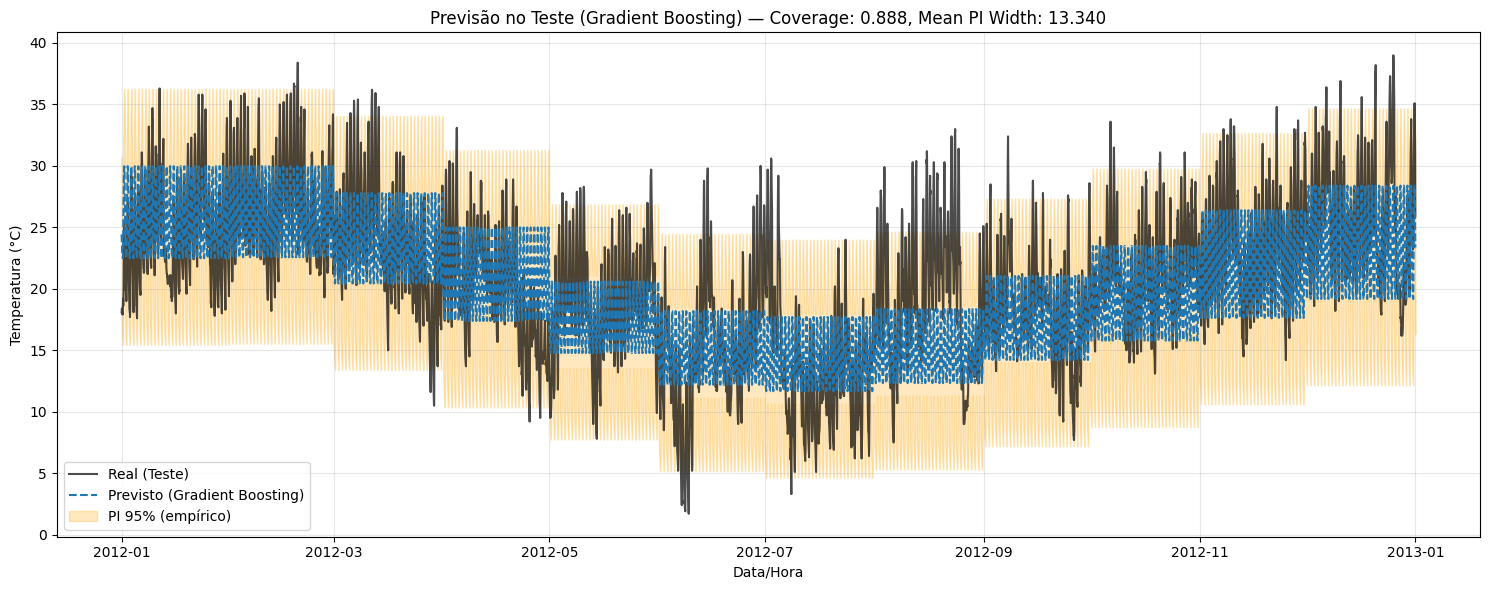

Coverage no Teste (95% empírico): 0.888
Largura média do PI no Teste: 13.340


In [5]:
# ==============================================================================
# 5. MODELAGEM E AVALIAÇÃO (Sliding-window k-fold para séries temporais)
# ==============================================================================
print("\n=== 5. MODELAGEM (Sliding-window k-fold) ===")

import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

# --- CHECAGEM PRELIMINAR: É apropriado usar intervalos de previsão empíricos? ---
# Heurística rápida: verifica tamanho da série, missing, estacionariedade, autocorrelação,
# heteroscedasticidade e presença de outliers.

target = 'TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)'
series = df[target].dropna()

n = len(series)
pct_missing = df[target].isna().mean()
unique_vals = series.nunique()

print(f"\n-- Pré-checagem para uso de PIs empíricos na série '{target}' --")
print(f"Tamanho da série (n): {n}")
print(f"Percentual de missing: {pct_missing:.2%}")
print(f"Valores únicos: {unique_vals}")

# Estatísticas de outliers
s_mean = series.mean()
s_std = series.std()
pct_outliers = ((series - s_mean).abs() > 3 * s_std).mean()
print(f"Percentual de outliers (>3σ): {pct_outliers:.2%}")

# Rolling std para checar heteroscedasticidade
rolling_std = series.rolling(window=24, min_periods=12).std()
if rolling_std.dropna().empty:
    std_cv = np.nan
else:
    std_cv = rolling_std.std() / (rolling_std.mean() if rolling_std.mean() != 0 else np.nan)
print(f"Coeficiente de variação da volatilidade (rolling std CV): {std_cv:.3f}")

# Testes ADF e ACF — requer statsmodels
adf_p = None
acf_info = None
try:
    from statsmodels.tsa.stattools import adfuller, acf
    # ADF
    try:
        adf_res = adfuller(series)
        adf_stat, adf_p = adf_res[0], adf_res[1]
        print(f"ADF stat: {adf_stat:.3f}, p-value: {adf_p:.4f}")
    except Exception as e:
        print(f"Falha ao rodar ADF: {e}")
    # ACF
    try:
        acf_vals = acf(series, nlags=min(72, max(24, int(n/10))), fft=False)
        # conta autocorrelações fortes além do lag 0
        strong_acf = np.sum(np.abs(acf_vals[1:]) > 0.2)
        print(f"Autocorrelações |ACF|>0.2 nos primeiros lags: {strong_acf}")
        acf_info = acf_vals
    except Exception as e:
        print(f"Falha ao calcular ACF: {e}")
except Exception:
    print('statsmodels não disponível. Instale via `pip install statsmodels` para ADF/ACF.')

# Decisão heurística (orientativa):
reasons = []
allow_empirical_pi = True

if n < 200:
    reasons.append('Amostra pequena (n < 200) — quantis empíricos instáveis')
    allow_empirical_pi = False
if pct_missing > 0.05:
    reasons.append('Alto percentual de missing (>5%) — imputar/tratar antes')
    allow_empirical_pi = False
if pct_outliers > 0.02:
    reasons.append('Mais de 2% de outliers (>3σ) — considerar tratamento')
if not np.isnan(std_cv) and std_cv > 0.5:
    reasons.append('Evidência de heteroscedasticidade (rolling std CV alto)')
    # heteroscedasticidade torna quantis fixos menos confiáveis
    allow_empirical_pi = False
if adf_p is not None and adf_p > 0.05:
    reasons.append('Série possivelmente não estacionária (ADF p>0.05) — modelar tendência antes')
    # não bloqueia completamente, mas recomenda cautela

if acf_info is not None and np.sum(np.abs(acf_info[1:]) > 0.5) > 0:
    reasons.append('Autocorrelação forte detectada em lags iniciais — resíduos provavelmente correlacionados')
    # não necessariamente proíbe, mas indica necessidade de métodos que preservem dependência

print('\n--- Resumo da pré-checagem ---')
if allow_empirical_pi:
    print('Empirical PI: OK para uso com cautela. Motivos: nenhuma condição bloqueante detectada.')
else:
    print('Empirical PI: NÃO recomendado sem ajustes. Motivos:')
    for r in reasons:
        print(' -', r)

print('\nRecomendações:')
print(' - Se usar PIs empíricos, faça validação temporal (sliding-window) e verifique cobertura em holdout.')
print(' - Alternativas: conformal prediction para séries (block-conformal), regressão quantílica, modelos probabilísticos ou bootstrap em blocos.')

pi_precheck = {'allow_empirical_pi': allow_empirical_pi, 'reasons': reasons}

# --- Continua o processo de modelagem (configuração de modelos e sliding-window) ---

# Configuração dos modelos (sem GridSearch)
models_params = {
    'Random Forest': {
        'pipeline': Pipeline([('scaler', StandardScaler()), ('model', RandomForestRegressor(random_state=42))])
    },
    'Gradient Boosting': {
        'pipeline': Pipeline([('scaler', StandardScaler()), ('model', GradientBoostingRegressor(random_state=42))])
    }
}

# Parâmetros do sliding-window k-fold
k = 5  # número de janelas/ folds sobre o conjunto de validação
use_expanding_train = True  # True = treino expande com janelas anteriores; False = janela de treino fixa
train_window = None  # se use_expanding_train False, defina número inteiro de passos para janela de treino

results_data = []
trained_models = {}
pi_stats = {}

# Pre-cálculo: dividir X_val / y_val em k blocos contíguos
n_val = len(X_val)
if n_val == 0:
    raise ValueError('X_val está vazio — verifique os cortes temporais')
block_size = int(np.ceil(n_val / k))

for name, cfg in models_params.items():
    print(f"\n--> Treinando por sliding-window: {name}...")
    pipeline = cfg.get('pipeline')

    fold_preds = []
    fold_trues = []
    fold_residuals = []
    fold_times = []

    for fold in range(k):
        start_idx = fold * block_size
        end_idx = min((fold + 1) * block_size, n_val)
        if start_idx >= end_idx:
            break  # sem mais blocos

        # índices do bloco de validação (no eixo temporal)
        val_index = X_val.index[start_idx:end_idx]

        # Construir conjunto de treino para este fold
        if use_expanding_train:
            # treino = X_train + X_val anteriores ao bloco atual
            if start_idx == 0:
                X_train_fold = X_train.copy()
                y_train_fold = y_train.copy()
            else:
                X_train_fold = pd.concat([X_train, X_val.iloc[:start_idx]])
                y_train_fold = pd.concat([y_train, y_val.iloc[:start_idx]])
        else:
            # janela fixa antes do bloco de validação
            # combinamos train+val para poder tomar a janela imediatamente anterior ao bloco
            combined_X = pd.concat([X_train, X_val])
            combined_y = pd.concat([y_train, y_val])
            # posição inicial do bloco no combined
            combined_start = len(X_train) + start_idx
            train_start = max(0, combined_start - train_window)
            train_end = combined_start
            X_train_fold = combined_X.iloc[train_start:train_end]
            y_train_fold = combined_y.iloc[train_start:train_end]

        # Treina o pipeline neste fold
        t0 = time.time()
        pipeline.fit(X_train_fold, y_train_fold)
        fold_times.append(time.time() - t0)

        # Previsão no bloco de validação
        y_pred_fold = pipeline.predict(X_val.loc[val_index])
        y_true_fold = y_val.loc[val_index]

        fold_preds.append(pd.Series(y_pred_fold, index=val_index))
        fold_trues.append(y_true_fold)
        fold_residuals.append(pd.Series(y_true_fold.values - y_pred_fold, index=val_index))

    # Concatena resultados dos folds
    if len(fold_preds) == 0:
        print('Nenhum fold executado para', name)
        continue

    y_pred_all = pd.concat(fold_preds).sort_index()
    y_true_all = pd.concat(fold_trues).sort_index()
    # concatena resíduos preservando índices
    residuals_all = pd.concat(fold_residuals).sort_index()

    # Métricas agregadas sobre todos os folds
    rmse = np.sqrt(mean_squared_error(y_true_all, y_pred_all))
    mae = mean_absolute_error(y_true_all, y_pred_all)
    mape = mean_absolute_percentage_error(y_true_all, y_pred_all) * 100
    r2 = r2_score(y_true_all, y_pred_all)
    avg_train_time = np.mean(fold_times) if fold_times else None

    # PI empírico a partir dos resíduos agregados (usar .values para quantil)
    lower_q, upper_q = np.quantile(residuals_all.values, [0.025, 0.975])
    lower_all = y_pred_all + lower_q
    upper_all = y_pred_all + upper_q
    coverage = np.mean((y_true_all >= lower_all) & (y_true_all <= upper_all))
    mean_width = np.mean(upper_all - lower_all)

    # Guarda stats e modelo (armazena o pipeline treinado no último fold)
    pi_stats[name] = {'lower_q': float(lower_q), 'upper_q': float(upper_q)}
    trained_models[name] = pipeline

    results_data.append({
        'Modelo': name,
        'RMSE': float(rmse),
        'MAE': float(mae),
        'MAPE (%)': float(mape),
        'R2 Score': float(r2),
        'Tempo Treino (s)': float(avg_train_time) if avg_train_time is not None else None,
        'Coverage (95%)': float(coverage),
        'Mean PI Width': float(mean_width)
    })

    print(f"    RMSE: {rmse:.4f} | MAE: {mae:.4f} | MAPE: {mape:.2f}% | R2: {r2:.4f} | Coverage: {coverage:.3f} | MeanWidth: {mean_width:.3f}")

# Exibe ranking
# define o índice como o nome do modelo para facilitar lookup posterior
df_results = pd.DataFrame(results_data).set_index('Modelo').sort_values(by='RMSE')
print("\n=== RANKING DE MODELOS (sliding-window) ===")
from IPython.display import display

display(df_results)

# Re-treinar o melhor modelo em todo o conjunto de treino+val (para previsão no teste)
best_name = df_results['RMSE'].idxmin()
best_pipeline = trained_models[best_name]
print(f"\n>>> Re-treinando o melhor modelo ({best_name}) em Train+Val para avaliar no Teste...")
combined_X_train = pd.concat([X_train, X_val])
combined_y_train = pd.concat([y_train, y_val])
best_pipeline.fit(combined_X_train, combined_y_train)

# Previsão final no Teste (garantir Series alinhada ao índice de X_test)
y_final = pd.Series(best_pipeline.predict(X_test), index=X_test.index)

# --- Métricas de avaliação no Teste (com base na predição completa) ---
rmse_test = np.sqrt(mean_squared_error(y_test, y_final))
mae_test = mean_absolute_error(y_test, y_final)
mape_test = mean_absolute_percentage_error(y_test, y_final) * 100
r2_test = r2_score(y_test, y_final)

print("\n=== MÉTRICAS NO TESTE ===")
print(f"RMSE (Teste): {rmse_test:.4f}")
print(f"MAE (Teste): {mae_test:.4f}")
print(f"MAPE (Teste): {mape_test:.2f}%")
print(f"R2 (Teste): {r2_test:.4f}")

# Anexar métricas ao df_results para referência (colunas novas)
df_results.loc[best_name, 'RMSE_test'] = float(rmse_test)
df_results.loc[best_name, 'MAE_test'] = float(mae_test)
df_results.loc[best_name, 'MAPE_test (%)'] = float(mape_test)
df_results.loc[best_name, 'R2_test'] = float(r2_test)

# PI no teste usando quantis empíricos obtidos nos folds
stats = pi_stats.get(best_name)
if stats is not None:
    lower_q = stats['lower_q']
    upper_q = stats['upper_q']
else:
    # calcular std do erro no conjunto combinado (usar Series alinhada)
    train_pred_combined = pd.Series(best_pipeline.predict(combined_X_train), index=combined_X_train.index)
    err_std = np.std((combined_y_train - train_pred_combined).values)
    lower_q = -1.96 * err_std
    upper_q = 1.96 * err_std

lower_test = y_final + lower_q
upper_test = y_final + upper_q
coverage_test = np.mean((y_test >= lower_test) & (y_test <= upper_test))
mean_width_test = np.mean((upper_test - lower_test).values)

plt.figure(figsize=(15, 6))
plt.plot(y_test.index, y_test, label='Real (Teste)', color='black', linewidth=1.5, alpha=0.7)
plt.plot(y_test.index, y_final, label=f'Previsto ({best_name})', linestyle='--', linewidth=1.5)
# passar arrays para fill_between (mesma ordem que y_test.index)
plt.fill_between(y_test.index, lower_test.values, upper_test.values, color='orange', alpha=0.25, label='PI 95% (empírico)')
plt.title(f'Previsão no Teste ({best_name}) — Coverage: {coverage_test:.3f}, Mean PI Width: {mean_width_test:.3f}')
plt.xlabel('Data/Hora')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Coverage no Teste (95% empírico): {coverage_test:.3f}")
print(f"Largura média do PI no Teste: {mean_width_test:.3f}")



=== 6. RESULTADOS FINAIS ===

--- Tabela de Performance ---


,RMSE,R2 Score,MAE,Tempo Treino (s),Coverage (95%),Mean PI Width
Modelo,,,,,,
Random Forest,3.272791,0.690704,2.512995,0.320961,0.950000,13.321553
Gradient Boosting,3.262762,0.692597,2.498988,0.194566,0.950342,13.339740


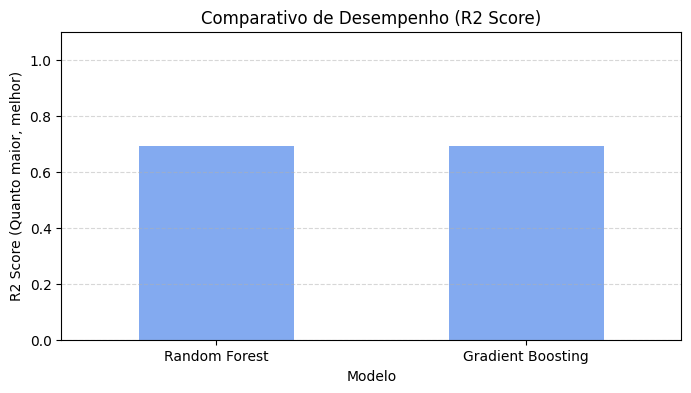


>>> CAMPEÃO: Gradient Boosting
>>> R2 Score: 0.6926


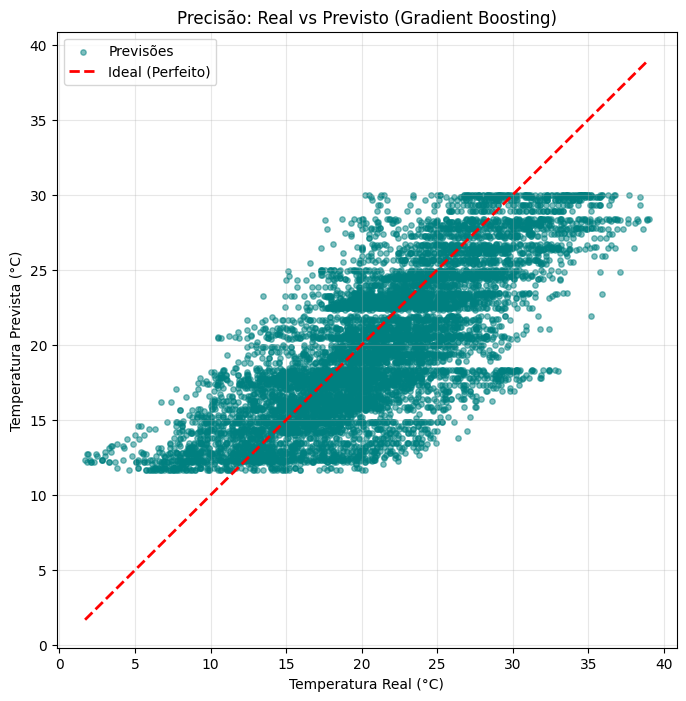

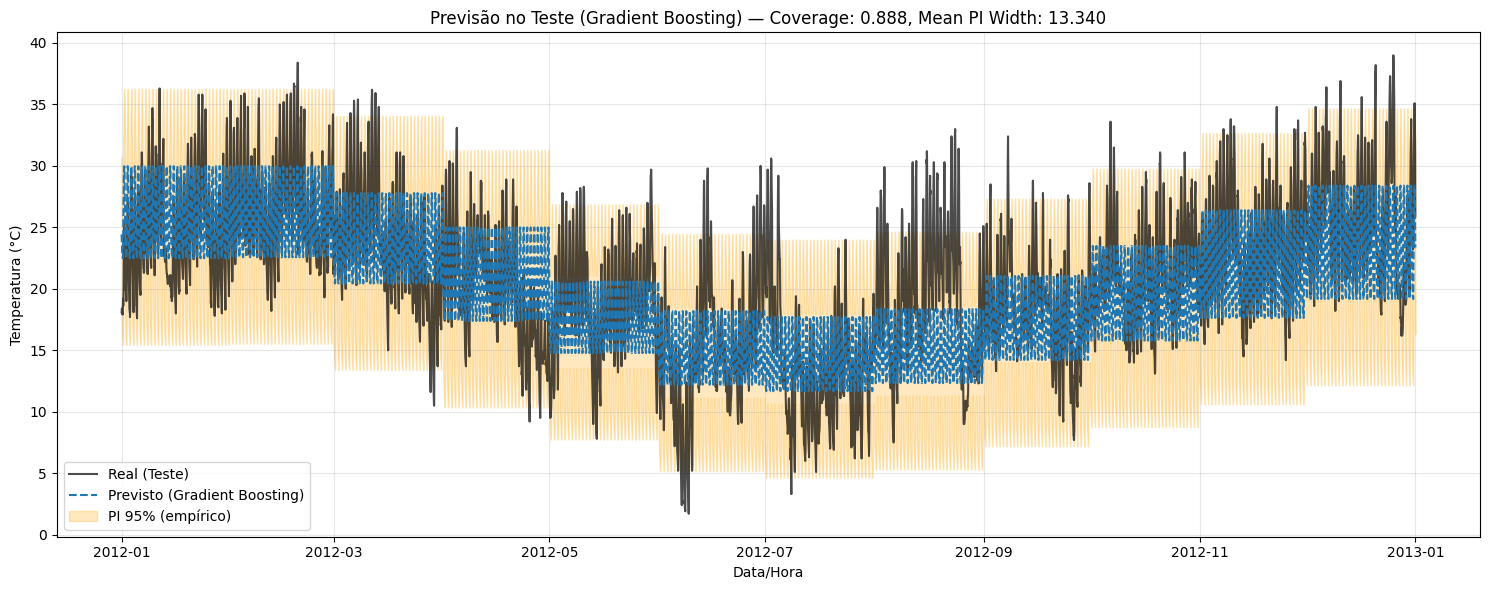

Coverage no Teste (95% empírico): 0.888
Largura média do PI no Teste: 13.340


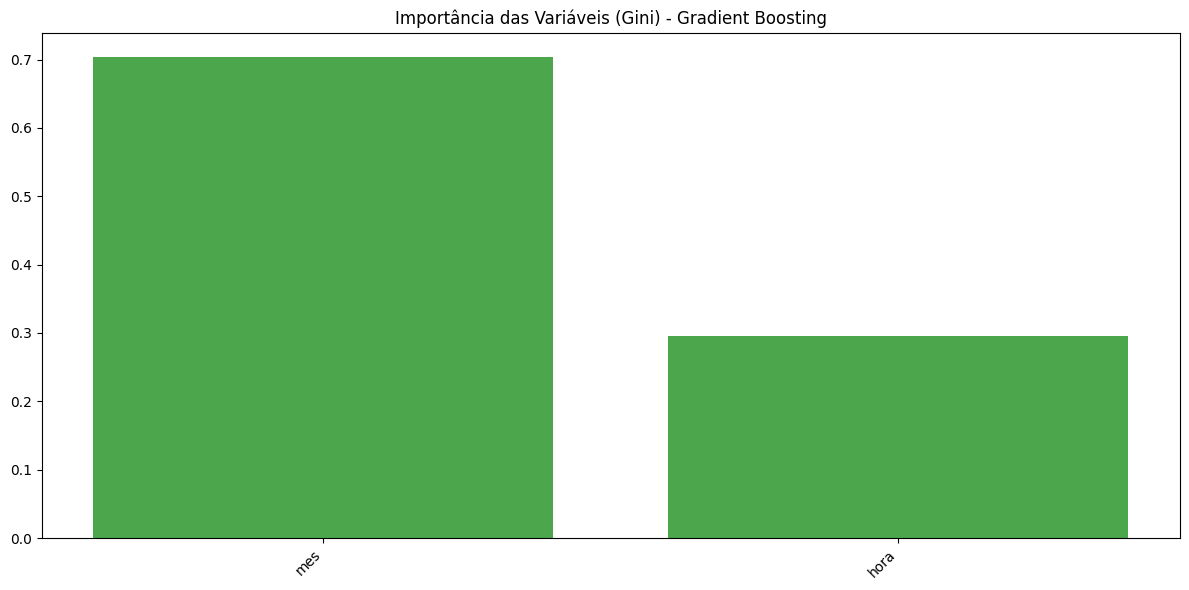

In [35]:
# ==============================================================================
# 6. RESULTADOS FINAIS E VISUALIZAÇÃO DETALHADA
# ==============================================================================
print("\n=== 6. RESULTADOS FINAIS ===")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Tabela Comparativa
# Cria um DataFrame com os dados coletados na etapa anterior
# assume que df_results já tem índice `Modelo` (definido no passo anterior)
if 'Modelo' in pd.DataFrame(results_data).columns:
    df_results = pd.DataFrame(results_data).set_index('Modelo')
else:
    df_results = pd.DataFrame(results_data)

print("\n--- Tabela de Performance ---")
display(df_results[['RMSE', 'R2 Score', 'MAE', 'Tempo Treino (s)', 'Coverage (95%)', 'Mean PI Width']])

# 2. Gráfico Comparativo de R2 Score
plt.figure(figsize=(8, 4))
df_results['R2 Score'].plot(kind='bar', color='cornflowerblue', alpha=0.8)
plt.title('Comparativo de Desempenho (R2 Score)')
plt.ylabel('R2 Score (Quanto maior, melhor)')
plt.ylim(0, 1.1) # Margem para visualização
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# 3. Identificação do Melhor Modelo
# agora df_results está indexado por 'Modelo', idxmax/idxmin retornam o nome do modelo
best_name = df_results['R2 Score'].idxmax()
best_model_pipeline = trained_models[best_name]
print(f"\n>>> CAMPEÃO: {best_name}")
print(f">>> R2 Score: {df_results.loc[best_name, 'R2 Score']:.4f}")

# 4. Gráfico de Dispersão: Real vs Previsto (O Teste de Fogo)
# Se os pontos seguirem a linha vermelha, o modelo é perfeito.
# usa pipeline para prever diretamente X_test (entrada crua)
y_final = best_model_pipeline.predict(X_test)

plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_final, alpha=0.5, s=15, color='teal', label='Previsões')

# Linha de referência (Ideal)
min_val = min(y_test.min(), np.min(y_final))
max_val = max(y_test.max(), np.max(y_final))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Ideal (Perfeito)')

plt.xlabel('Temperatura Real (°C)')
plt.ylabel('Temperatura Prevista (°C)')
plt.title(f'Precisão: Real vs Previsto ({best_name})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# --- Agora, adiciona Intervalo de Previsão (PI) para o conjunto de TESTE usando pi_stats ---
stats = pi_stats.get(best_name, None)
if stats is not None:
    lower_q = stats['lower_q']
    upper_q = stats['upper_q']
else:
    # fallback gaussiano se pi_stats não existir
    err_std = np.std((combined_y_train - best_model_pipeline.predict(combined_X_train)))
    lower_q = -1.96 * err_std
    upper_q = 1.96 * err_std

lower_test = y_final + lower_q
upper_test = y_final + upper_q
coverage_test = np.mean((y_test >= lower_test) & (y_test <= upper_test))
mean_width_test = np.mean(upper_test - lower_test)

plt.figure(figsize=(15, 6))
plt.plot(y_test.index, y_test, label='Real (Teste)', color='black', linewidth=1.5, alpha=0.7)
plt.plot(y_test.index, y_final, label=f'Previsto ({best_name})', linestyle='--', linewidth=1.5)
plt.fill_between(y_test.index, lower_test, upper_test, color='orange', alpha=0.25, label='PI 95% (empírico)')
plt.title(f'Previsão no Teste ({best_name}) — Coverage: {coverage_test:.3f}, Mean PI Width: {mean_width_test:.3f}')
plt.xlabel('Data/Hora')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Coverage no Teste (95% empírico): {coverage_test:.3f}")
print(f"Largura média do PI no Teste: {mean_width_test:.3f}")

# 5. Importância das Features (Adaptável para Árvores ou Regressão Linear)
plt.figure(figsize=(12, 6))
features = combined_X_train.columns.tolist()

if hasattr(best_model_pipeline.named_steps['model'], 'feature_importances_'):
    # Para Random Forest e Gradient Boosting
    importances = best_model_pipeline.named_steps['model'].feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.bar(range(len(features)), importances[indices], color='green', alpha=0.7)
    plt.xticks(range(len(features)), [features[i] for i in indices], rotation=45, ha='right')
    plt.title(f"Importância das Variáveis (Gini) - {best_name}")

elif hasattr(best_model_pipeline.named_steps['model'], 'coef_'):
    # Para Regressão Linear (mostra coeficientes positivos/negativos)
    importances = best_model_pipeline.named_steps['model'].coef_
    if importances.ndim > 1: importances = importances.flatten()

    indices = np.argsort(abs(importances))[::-1] # Ordena pelo impacto absoluto

    # Cores: Azul (Impacto Positivo) / Vermelho (Impacto Negativo)
    colors = ['blue' if x > 0 else 'red' for x in importances[indices]]

    plt.bar(range(len(features)), importances[indices], color=colors, alpha=0.7)
    plt.xticks(range(len(features)), [features[i] for i in indices], rotation=45, ha='right')
    plt.title(f"Impacto das Variáveis (Coeficientes) - {best_name}")
    plt.axhline(0, color='black', linewidth=0.8) # Linha do zero

plt.tight_layout()
plt.show()
